# FAIRshake Evaluation Summary

In [46]:
print("Created by Brian Schilder, 07/22/2018\n")
import sys
print("Python Version Info:")
print(sys.version)


Created by Brian Schilder, 07/22/2018

Python Version Info:
3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 03:03:55) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


## Summary Questions
- Average score for each question
- Standard deviation for each answer
- Correlation between questions
- Evals per person, max evals, and distribution
- Are some people generally harsher
- Which answers tended to have comments
- FAIRest tools vs. Least FAIR tools

## FAIRshake Questions
1. DESCRIPTION : The tool has a unique name and an informative description.
2. DOWNLOAD : The tool can be freely downloaded or accessed from a webpage.
3. ONTOLOGY : The tool utilizes a community-accepted ontology.
4. TUTORIAL : Tutorials for the tool are available on the tool‚Äôs homepage.
5. SOURCE CODE : Source code is shared in a public repository and is documented.
6. VERSIONING : Previous versions of the tool are made available.
7. CONTACT: Contact information is provided for the creator(s) of the tool and information describing how to cite the tool is provided.
8. API : The tool can be accessed programmatically through an API and follows community standards for open APIs.
9. LICENSE : Licensing information is provided on the tool's homepage.


In [47]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib
# matplotlib.rcParams.update({'font.size': 18})

import pandas as pd
fair = pd.read_csv("merged_FAIRshake_evals.csv", index_col=None)
fair['q_id'] = pd.Categorical(fair['q_id'])
fair.shape
fair.columns

qDict = {1:'1. Description', 2:'2. Download', 3:'3. Ontology', 4:'4. Tutorial', 
         5:'5. Source Code', 6:'6. Versioning', 7:'7. Contact', 8:'8. API', 9:'9. License'}
fair["q_name"] = fair['q_id'].map(qDict)


## Average score for each question

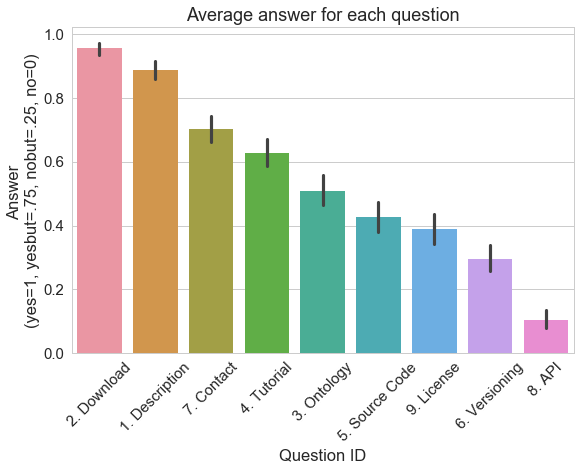

In [48]:
import seaborn as sn
sn.set(font_scale=1.5)
import matplotlib.pyplot as plt
sn.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(9, 6)) #default figsize = (8,6) 

fair.answer.unique()
fair["answer01"] = fair.answer.map(dict(yes=1, no=0, yesbut=.75, nobut=.25))
avg_per_q = fair.groupby('q_name')['q_name','answer01'].mean()
std_per_q = fair.groupby('q_name')['q_name','answer01'].std()
avg_per_q.rename(columns={'answer01':'answer01_mean'}, inplace=True)
avg_per_q = avg_per_q.sort_values(by='answer01_mean', ascending=False)

# plot
# fair = fair.merge(avg_per_q, on='q_id')
g = sn.barplot(data=fair, x='q_name', y='answer01', order=avg_per_q.index)
# ax = sn.violinplot(data=fair, x='q_id', y='answer01', order=avg_per_q.index)
g.set(ylabel='Answer \n(yes=1, yesbut=.75, nobut=.25, no=0)', xlabel='Question ID', title="Average answer for each question")
plt.xticks(rotation=45, ha='center')
plt.show()



## Frequency of each of the 4 score options for each question

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

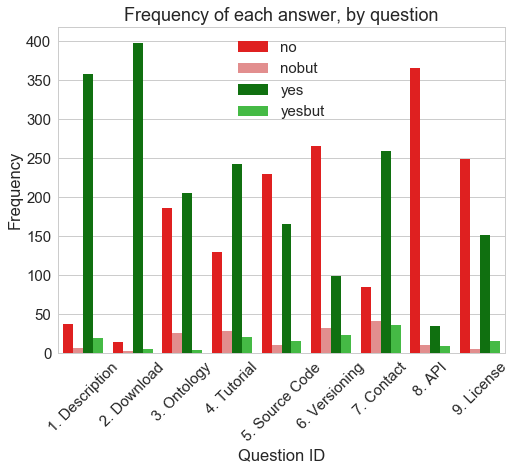

In [49]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

scores4 = fair.groupby(['q_name','answer'])['answer'].count()
scores4.name = 'answerCount'
scores4 = scores4.reset_index()
palette ={"no":"red","nobut":"lightcoral", "yes":"green", "yesbut":"limegreen"}
g = sn.barplot(data=scores4, x='q_name', y='answerCount', hue='answer', palette=palette)
g.set(ylabel='Frequency', xlabel='Question ID', title="Frequency of each answer, by question")
g.legend()
plt.xticks(rotation=45, ha='center')

## Correlations between questions

There is some correlation between q1 (Description) and q2 (Download).


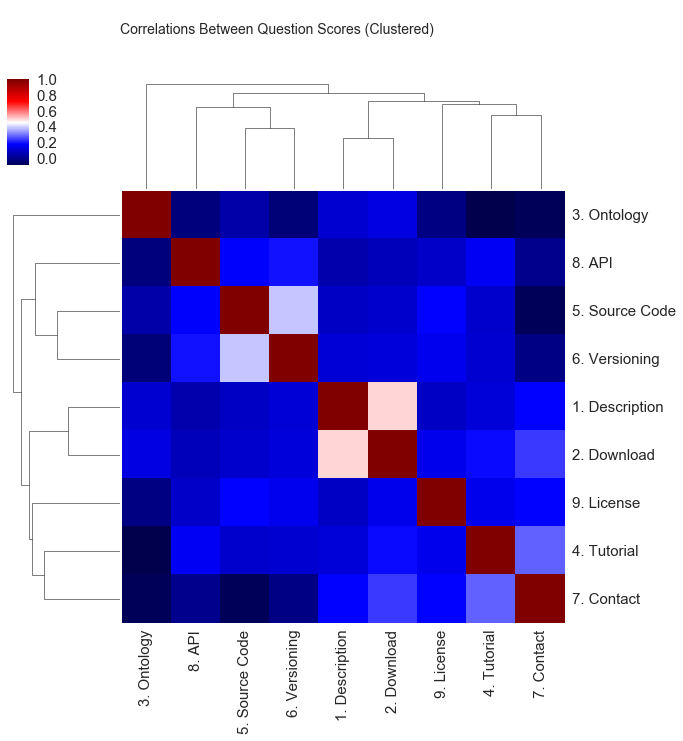

In [50]:
# fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

corrDict={}
for q in fair['q_name']:
    sub = fair.loc[fair['q_name']==q]['answer01']
    corrDict[q] = sub.values
corrMatrix = pd.DataFrame(corrDict).corr()

# g = sn.heatmap(corrMatrix, annot=True, cmap='seismic')
g = sn.clustermap(data=corrMatrix, cmap='seismic').fig.suptitle('\nCorrelations Between Question Scores (Clustered)', size=14) 
# g.set(ylabel='Question ID', xlabel='Question ID', title="Correlations between all questions")

print("There is some correlation between q1 (Description) and q2 (Download).")


## Evaluations Per Person

[Text(0,0.5,'Frequency'),
 Text(0.5,0,'Number of Evaluations'),
 Text(0.5,1,'Evaluations/person\n Mean = 20.05  \n Max = 100')]

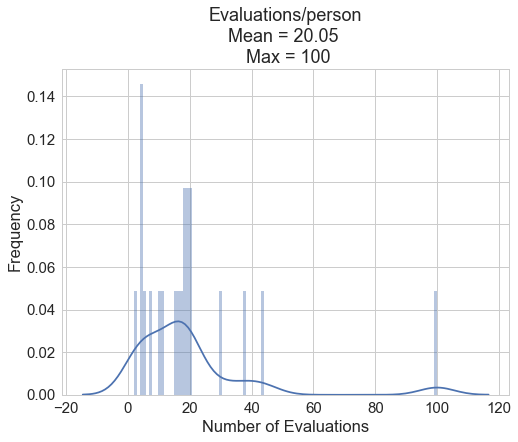

In [51]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

evalCounts = [len(x) for x in fair.groupby('user_id')['resource_name'].unique()]
avgCounts = sum(evalCounts)/len(evalCounts)


g = sn.distplot(evalCounts, bins=100)
g.set(xlabel='Number of Evaluations', ylabel='Frequency', 
       title="Evaluations/person\n Mean = "+str(round(avgCounts,2))+"  \n Max = "+str(max(evalCounts)))


## Are some raters harsher than others?

Evaluators gave a average FAIR score of 0.58 (on a 0-1 scale).


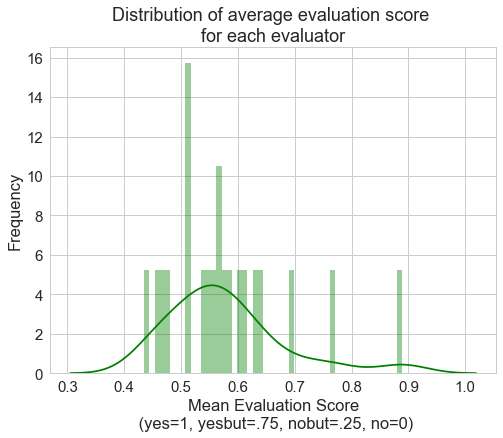

In [52]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

avgRating = fair.groupby('user_id')['user_id','answer01'].mean()
meanMean = avgRating['answer01'].mean()
g = sn.distplot(avgRating['answer01'], bins=50, color='green')
g.set(xlabel='Mean Evaluation Score\n (yes=1, yesbut=.75, nobut=.25, no=0)', ylabel='Frequency', 
       title="Distribution of average evaluation score \nfor each evaluator")

print("Evaluators gave a average FAIR score of "+str(round(meanMean,2)) + " (on a 0-1 scale).")

## Which answers tended to have the most comments

Questions 1. Description and 7. Contact most frequently had comments.


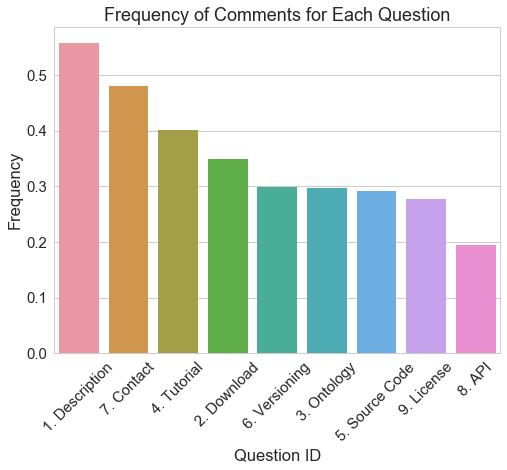

In [53]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

commentDict={}
for q in fair['q_name'].unique():
    sub = fair.loc[fair['q_name']==q]['comment']
    notEmpty = sum(~sub.isnull())/len(sub.isnull())
    commentDict[q] = notEmpty
commentDF = pd.Series(commentDict).sort_values(ascending=False)

g = sn.barplot(x=commentDF.index, y=commentDF )
g.set(xlabel='Question ID', ylabel='Frequency', 
       title="Frequency of Comments for Each Question")
plt.xticks(rotation=45, ha='center')
print("Questions "+commentDF.index[0]+" and "+commentDF.index[1]+ " most frequently had comments.")


## The FAIRest of the them all

FAIRest resources (score = 1.0)


,resource_name,answer01
0,Saccharomyces Genome Database,1.0
1,Canvas,1.0
2,HaploGrep 2,1.0




Least FAIR resources ( score = 0.0).


,resource_name,answer01
385,NetExplore,0.0
386,Ka-me,0.0
387,SpeeDB,0.0
388,Evoker,0.0
389,Mcheza,0.0
390,ConsensusPathDB,0.0
391,PAIR,0.0
392,gCUP,0.0
393,Bridging the scales,0.0
394,RepMaestro,0.0


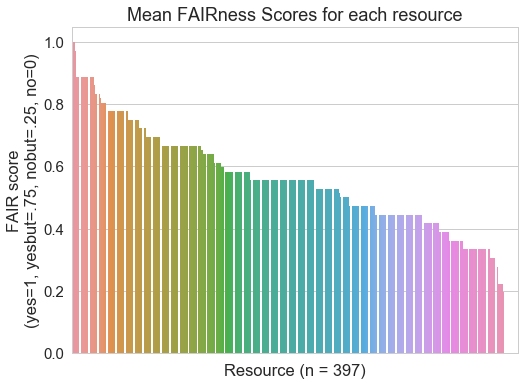

In [63]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

resourceScores = fair.groupby('resource_name')['answer01'].mean().sort_values(ascending=False).reset_index()
FAIRest = resourceScores.loc[resourceScores['answer01']==1,:]
leastFAIR  = resourceScores.loc[resourceScores['answer01']==0,:]

g = sn.barplot(data=resourceScores, x='resource_name', y='answer01')
g.set(xlabel='Resource (n = '+str(len(resourceScores))+')', ylabel='FAIR score\n(yes=1, yesbut=.75, nobut=.25, no=0)', 
       title="Mean FAIRness Scores for each resource")
g.set(xticklabels=[])

print("FAIRest resources (score = 1.0)")
print(FAIRest)
print("\n")
print("Least FAIR resources ( score = 0.0).")
print(leastFAIR)
